### 1. initalization

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
from tqdm import tqdm

2023-04-10 15:07:40.726525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 15:07:41.449731: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-10 15:07:41.449787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-10 15:07:41.449794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
EPSILON = 1e-8
FACTORS = [1, 1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32]

### 2. model

In [3]:
class WSConv2d(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1, gain=2):
        super(WSConv2d, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bias = self.conv.bias
        self.scale = (gain / (in_channels * kernel_size * kernel_size)) ** 0.5

        self.conv.weight.data.normal_(0, 1)
        self.bias.data.zero_()
        
    def forward(self, x):
        x = x * self.scale
        x = self.conv(x)
        x = x + self.bias.view(1, self.bias.shape[0], 1, 1)
        return x

In [4]:
class PixNorm(nn.Module):
    def __init__(self):
        super(PixNorm, self).__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + EPSILON)

In [5]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(CNNBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.use_pixelnorm = use_pixelnorm
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.pixelnorm = PixNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pixelnorm(x) if self.use_pixelnorm else x
        x = self.leaky(self.conv2(x))
        x = self.pixelnorm(x) if self.use_pixelnorm else x
        return x

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, rgb_channels=3):
        super(Generator, self).__init__()
        self.init_block = nn.Sequential(
            PixNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixNorm(),
        )

        self.init_rgb = WSConv2d(in_channels, rgb_channels, kernel_size=1, stride=1, padding=0)
        self.progress_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([self.init_rgb])

        for i in range(len(FACTORS) - 1):
            conv_in_channel  = int(in_channels * FACTORS[i])
            conv_out_channel = int(in_channels * FACTORS[i + 1])

            self.progress_blocks.append(CNNBlock(conv_in_channel, conv_out_channel))
            self.rgb_layers.append(WSConv2d(conv_out_channel, rgb_channels, kernel_size=1, stride=1, padding=0))

    def fade_in(self, alpha, upscale, generated):
        return torch.tanh(upscale * (1 - alpha) + generated * alpha)

    def forward(self, x, alpha, steps):
        out = self.init_block(x)

        if steps == 0:
            return self.init_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.progress_blocks[step](upscaled)

        final_upscale = self.rgb_layers[steps-1](upscaled)
        final_out = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscale, final_out)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, rgb_channels=3):
        super(Discriminator, self).__init__()
        self.progress_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        for i in range(len(FACTORS) - 1, 0, -1):
            conv_in_channel  = int(in_channels * FACTORS[i])
            conv_out_channel = int(in_channels * FACTORS[i - 1])

            self.progress_blocks.append(CNNBlock(conv_in_channel, conv_out_channel, use_pixelnorm=False))
            self.rgb_layers.append(WSConv2d(rgb_channels, conv_in_channel, kernel_size=1, stride=1, padding=0))

        self.init_rgb = WSConv2d(rgb_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.rgb_layers.append(self.init_rgb)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.final_block =  nn.Sequential(
            WSConv2d(in_channels+1, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, 1, kernel_size=1, stride=1, padding=0),
        )
    def fade_in(self, alpha, downscale, out):
        return alpha * out + (1 - alpha) * downscale

    def minibatch_std(self, x):
        batch_statistics = torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        current_step = len(self.progress_blocks) - steps
        out = self.leaky(self.rgb_layers[current_step](x))

        if steps == 0:
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        downscaled = self.leaky(self.rgb_layers[current_step+1](self.avg_pool(x)))
        out = self.avg_pool(self.progress_blocks[current_step](out))
        out = self.fade_in(alpha, downscaled, out)

        for step in range(current_step + 1, len(self.progress_blocks)):
            out = self.progress_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

#### Testing models

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Passed! 4
Passed! 8
Passed! 16
Passed! 32
Passed! 64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Passed! 128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Passed! 256
Passed! 512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Passed! 1024


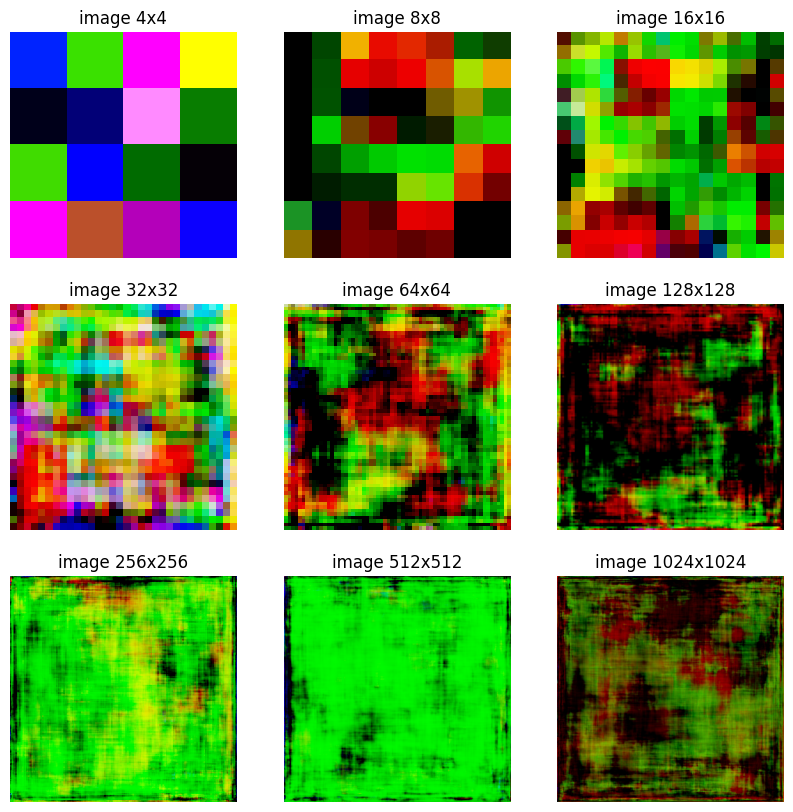

In [8]:
def tester():
    z_dim = 512
    in_channels = 256
    rgb_channels = 3
    alpha = 0.5
    gen = Generator(z_dim, in_channels, rgb_channels)
    disc = Discriminator(in_channels, rgb_channels)

    image_sizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024]

    from math import log2

    plt.figure(figsize=(10, 10))

    for i, image_size in enumerate(image_sizes):
        current_step = int(log2((image_size/4)))
        x = torch.rand((1, z_dim, 1, 1))
        out = gen(x, alpha=alpha, steps=current_step)
        assert out.shape == (1, 3, image_size, image_size), f"generator output shape is {out.shape} instead of (1, 3, {image_size}, {image_size})"

        plt.subplot(3,3,i+1)
        plt.axis('off') #hide coordinate axes
        plt.title(f'image {image_size}x{image_size}')

        plt.imshow(out.squeeze(0).detach().permute(1, 2, 0).cpu().numpy())

        out = disc(out, alpha=alpha, steps=current_step)
        assert out.shape == (1, 1), f"discriminator output shape is {out.shape} instead of (1, 1)"
        print(f"Passed! {image_size}")

    plt.show()

tester()

### 3. Load data

In [9]:
download = False
import os
if not os.path.exists("Anime-Face-Dataset"):
    !git clone --depth 1 https://github.com/bchao1/Anime-Face-Dataset.git

if not os.path.exists("data"):
    !mkdir data

if download:
    !cd Anime-Face-Dataset/src && python scrape.py

In [10]:
# maybe use torchvision.utils.make_grid


### 3. Training

In [11]:
config = { # Hyperparameters
    "image_dir": "./data",
    "num_workers": 4,
    "pin_memory": True,

    "epochs": [10, 20, 30, 30, 30, 30, 30],
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "lr": 0.0001,
    "save_model": True,
    "save_freq": 5,
    "load_model": True,
    "save_location": "./models/progan2.pt",
    "current_step": 0,
    "current_epoch": 0,

    "z_dim": 256,
    "alpha": 0.5,
    "in_channels": 256,
    "rgb_channels": 3,
    "lambda_gp": 10,
    "batch_sizes": [32, 32, 32, 16, 16, 16, 16],
    "image_sizes": [4, 8, 16, 32, 64, 128, 256],
    "log_dir": "./log/progan2",
    "tensorboard_step": 0,
}

assert len(config["epochs"]) == len(config["batch_sizes"]) == len(config["image_sizes"])

In [12]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def plot_tensorboard(writer, disc_loss, gen_loss, fake_images, real_images, config):
    writer.add_scalar("Loss discriminator", disc_loss, global_step=config["tensorboard_step"])
    writer.add_scalar("Loss generator", gen_loss, global_step=config["tensorboard_step"])

    with torch.no_grad():
        img_grid_real = utils.make_grid(real_images, normalize=True)
        img_grid_fake = utils.make_grid(fake_images, normalize=True)
        writer.add_image("Real", img_grid_real, global_step=config["tensorboard_step"])
        writer.add_image("Fake", img_grid_fake, global_step=config["tensorboard_step"])

def train(
    gen, 
    disc, 
    gen_optim, 
    disc_optim, 
    scaler_gen, 
    scaler_disc, 
    step, 
    train_loader, 
    data_size, 
    writer, 
    config
):
    loader = tqdm(train_loader, leave=True)
    alpha = config["alpha"]
    epochs = config["epochs"][step]

    gen = gen.to(config["device"])
    loader_len = len(loader)

    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(config["device"])
        batch_size = real.shape[0]

        noise = torch.randn(batch_size, config["z_dim"], 1, 1).to(config["device"])

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha=alpha, steps=step)
            disc_fake = disc(fake, alpha=alpha, steps=step)
            disc_real = disc(real, alpha=alpha, steps=step)

        gp = gradient_penalty(disc, real, fake, alpha, step, device=config["device"])
        loss_disc = (
            -(torch.mean(disc_real) - torch.mean(disc_fake))
            + gp * config["lambda_gp"]
            + 0.001 * torch.mean(disc_real * disc_real)
        ).to(config["device"])

        disc_optim.zero_grad()
        scaler_disc.scale(loss_disc).backward(retain_graph=True)
        scaler_disc.step(disc_optim)
        scaler_disc.update()

        with torch.cuda.amp.autocast():
            gen_fake = disc(fake, alpha=alpha, steps=step)
            loss_gen = -torch.mean(gen_fake).to(config["device"])

        gen_optim.zero_grad()
        scaler_gen.scale(loss_gen).backward(retain_graph=True)
        scaler_gen.step(gen_optim)
        scaler_gen.update()

        alpha += batch_size / (
            (epochs * 0.5) * data_size
        )

        alpha = min(alpha, 1)

        if batch_idx + 1 == loader_len:
            plot_tensorboard(
                writer, 
                loss_disc,
                loss_gen,
                fake.detach(), 
                real.detach(), 
                config,
            )
            config["tensorboard_step"] += 1

    config["alpha"] = alpha


In [13]:
from math import log2

def get_loader(generator_output_size, config):
    transform = transforms.Compose([
        transforms.Resize((generator_output_size, generator_output_size)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(
            mean=[0.5 for _ in range(config["rgb_channels"])], 
            std=[0.5 for _ in range(config["rgb_channels"])]
        ),
    ])

    current_step = int(log2((generator_output_size/4)))

    dataset = datasets.ImageFolder(config["image_dir"], transform=transform)
    loader = DataLoader(
        dataset, 
        batch_size=config["batch_sizes"][current_step], 
        shuffle=True,
        num_workers=config["num_workers"],
        pin_memory=config["pin_memory"]
    )

    return loader, dataset

def save_model(gen, disc, config):
    print("==> Saving models...")
    state = {
        "gen": gen.state_dict(),
        "disc": disc.state_dict(),
        "current_step": config["current_step"],
        "current_epoch": config["current_epoch"],
        "tensorboard_step": config["tensorboard_step"],
    }
    torch.save(state, config["save_location"])
    print(f"Saved to {config['save_location']}")

def load_model(config):
    print("==> Loading models...")
    state = torch.load(config["save_location"])
    print(f"Loaded from {config['save_location']}")
    return state

In [14]:

def main():
    z_dim, in_channels, rgb_channels = config["z_dim"], config["in_channels"], config["rgb_channels"]
    gen = Generator(z_dim, in_channels, rgb_channels).to(config["device"])
    disc = Discriminator(in_channels, rgb_channels).to(config["device"])

    if config["load_model"]:
        state = load_model(config)
        gen.load_state_dict(state["gen"])
        disc.load_state_dict(state["disc"])

        config["current_step"] = state["current_step"]
        config["current_epoch"] = state["current_epoch"]
        config["tensorboard_step"] = state["tensorboard_step"]

    print(f"\n======\ncurrent step: {config['current_step']}\ncurrent epoch: {config['current_epoch']}\ntensorboard step: {config['tensorboard_step']}\n======\n")

    gen_optim = torch.optim.Adam(gen.parameters(), lr=config["lr"], betas=(0.0, 0.99))
    disc_optim = torch.optim.Adam(disc.parameters(), lr=config["lr"], betas=(0.0, 0.99))

    gen.train()
    disc.train()

    scaler_gen = torch.cuda.amp.GradScaler()
    scaler_disc = torch.cuda.amp.GradScaler()

    writer = SummaryWriter(log_dir=config["log_dir"])

    for output_size in config["image_sizes"][config["current_step"]:]:
        steps = config["current_step"]

        print(f"Output size: {output_size}")
        loader, dataset = get_loader(output_size, config)

        epochs = config["epochs"][steps]
        while epochs != config["current_epoch"]:
            config["current_epoch"] += 1
            print(f"Epoch {config['current_epoch']%epochs}/{epochs}")
            train(
                gen, 
                disc, 
                gen_optim, 
                disc_optim, 
                scaler_gen, 
                scaler_disc, 
                steps, 
                loader, 
                len(dataset), 
                writer, 
                config
            )

            if config["save_model"] and config["tensorboard_step"] % config["save_freq"] == 0:
                if config["current_epoch"] % epochs == 0:
                    config["current_step"] += 1
                    save_model(gen, disc, config)
                    config["current_step"] -= 1
                else:
                    save_model(gen, disc, config)

        config["current_step"] += 1
        config["current_epoch"] = 0

    return gen, disc, gen_optim, disc_optim

gen, disc, _, _ = main()

==> Loading models...
Loaded from ./models/progan2.pt

current step: 2
current epoch: 25
tensorboard step: 53

Output size: 16
Epoch 26/30


100%|██████████| 1987/1987 [01:48<00:00, 18.33it/s]


Epoch 27/30


100%|██████████| 1987/1987 [01:50<00:00, 18.01it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 28/30


100%|██████████| 1987/1987 [01:55<00:00, 17.17it/s]


Epoch 29/30


100%|██████████| 1987/1987 [01:49<00:00, 18.09it/s]


Epoch 0/30


100%|██████████| 1987/1987 [01:52<00:00, 17.68it/s]


Output size: 32
Epoch 1/30


100%|██████████| 3973/3973 [06:56<00:00,  9.53it/s]


Epoch 2/30


100%|██████████| 3973/3973 [06:55<00:00,  9.56it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 3/30


100%|██████████| 3973/3973 [06:56<00:00,  9.55it/s]


Epoch 4/30


100%|██████████| 3973/3973 [06:54<00:00,  9.59it/s]


Epoch 5/30


100%|██████████| 3973/3973 [06:55<00:00,  9.56it/s]


Epoch 6/30


100%|██████████| 3973/3973 [06:55<00:00,  9.57it/s]


Epoch 7/30


100%|██████████| 3973/3973 [06:54<00:00,  9.59it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 8/30


100%|██████████| 3973/3973 [06:55<00:00,  9.56it/s]


Epoch 9/30


100%|██████████| 3973/3973 [06:54<00:00,  9.59it/s]


Epoch 10/30


100%|██████████| 3973/3973 [06:55<00:00,  9.57it/s]


Epoch 11/30


100%|██████████| 3973/3973 [06:57<00:00,  9.51it/s]


Epoch 12/30


100%|██████████| 3973/3973 [06:49<00:00,  9.70it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 13/30


100%|██████████| 3973/3973 [06:52<00:00,  9.63it/s]


Epoch 14/30


100%|██████████| 3973/3973 [06:54<00:00,  9.60it/s]


Epoch 15/30


100%|██████████| 3973/3973 [06:52<00:00,  9.63it/s]


Epoch 16/30


100%|██████████| 3973/3973 [06:53<00:00,  9.61it/s]


Epoch 17/30


100%|██████████| 3973/3973 [06:56<00:00,  9.54it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 18/30


100%|██████████| 3973/3973 [06:56<00:00,  9.53it/s]


Epoch 19/30


100%|██████████| 3973/3973 [06:55<00:00,  9.55it/s]


Epoch 20/30


100%|██████████| 3973/3973 [06:53<00:00,  9.60it/s]


Epoch 21/30


100%|██████████| 3973/3973 [06:53<00:00,  9.60it/s]


Epoch 22/30


100%|██████████| 3973/3973 [06:57<00:00,  9.52it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 23/30


100%|██████████| 3973/3973 [06:53<00:00,  9.60it/s]


Epoch 24/30


100%|██████████| 3973/3973 [06:58<00:00,  9.49it/s]


Epoch 25/30


100%|██████████| 3973/3973 [06:56<00:00,  9.55it/s]


Epoch 26/30


100%|██████████| 3973/3973 [06:56<00:00,  9.53it/s]


Epoch 27/30


100%|██████████| 3973/3973 [06:58<00:00,  9.50it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 28/30


100%|██████████| 3973/3973 [06:58<00:00,  9.50it/s]


Epoch 29/30


100%|██████████| 3973/3973 [06:57<00:00,  9.51it/s]


Epoch 0/30


100%|██████████| 3973/3973 [06:55<00:00,  9.56it/s]


Output size: 64
Epoch 1/30


100%|██████████| 3973/3973 [19:31<00:00,  3.39it/s]


Epoch 2/30


100%|██████████| 3973/3973 [19:32<00:00,  3.39it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 3/30


100%|██████████| 3973/3973 [19:33<00:00,  3.39it/s]


Epoch 4/30


100%|██████████| 3973/3973 [19:35<00:00,  3.38it/s]


Epoch 5/30


100%|██████████| 3973/3973 [19:30<00:00,  3.39it/s]


Epoch 6/30


100%|██████████| 3973/3973 [19:25<00:00,  3.41it/s]


Epoch 7/30


100%|██████████| 3973/3973 [19:26<00:00,  3.40it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 8/30


100%|██████████| 3973/3973 [19:46<00:00,  3.35it/s]


Epoch 9/30


100%|██████████| 3973/3973 [19:44<00:00,  3.35it/s]


Epoch 10/30


100%|██████████| 3973/3973 [19:49<00:00,  3.34it/s]


Epoch 11/30


100%|██████████| 3973/3973 [19:37<00:00,  3.37it/s]


Epoch 12/30


100%|██████████| 3973/3973 [19:32<00:00,  3.39it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 13/30


100%|██████████| 3973/3973 [19:30<00:00,  3.40it/s]


Epoch 14/30


100%|██████████| 3973/3973 [19:34<00:00,  3.38it/s]


Epoch 15/30


100%|██████████| 3973/3973 [19:29<00:00,  3.40it/s]


Epoch 16/30


100%|██████████| 3973/3973 [19:31<00:00,  3.39it/s]


Epoch 17/30


100%|██████████| 3973/3973 [19:28<00:00,  3.40it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 18/30


100%|██████████| 3973/3973 [19:26<00:00,  3.41it/s]


Epoch 19/30


100%|██████████| 3973/3973 [19:30<00:00,  3.39it/s]


Epoch 20/30


100%|██████████| 3973/3973 [19:26<00:00,  3.41it/s]


Epoch 21/30


100%|██████████| 3973/3973 [19:26<00:00,  3.41it/s]


Epoch 22/30


100%|██████████| 3973/3973 [19:23<00:00,  3.41it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 23/30


100%|██████████| 3973/3973 [19:20<00:00,  3.42it/s]


Epoch 24/30


100%|██████████| 3973/3973 [19:21<00:00,  3.42it/s]


Epoch 25/30


100%|██████████| 3973/3973 [19:19<00:00,  3.43it/s]


Epoch 26/30


100%|██████████| 3973/3973 [19:19<00:00,  3.43it/s]


Epoch 27/30


100%|██████████| 3973/3973 [19:19<00:00,  3.43it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 28/30


100%|██████████| 3973/3973 [19:18<00:00,  3.43it/s]


Epoch 29/30


100%|██████████| 3973/3973 [19:18<00:00,  3.43it/s]


Epoch 0/30


100%|██████████| 3973/3973 [19:18<00:00,  3.43it/s]


Output size: 128
Epoch 1/30


100%|██████████| 3973/3973 [40:31<00:00,  1.63it/s]


Epoch 2/30


100%|██████████| 3973/3973 [40:30<00:00,  1.63it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 3/30


100%|██████████| 3973/3973 [40:30<00:00,  1.63it/s]


Epoch 4/30


100%|██████████| 3973/3973 [40:28<00:00,  1.64it/s]


Epoch 5/30


100%|██████████| 3973/3973 [40:28<00:00,  1.64it/s]


Epoch 6/30


100%|██████████| 3973/3973 [40:27<00:00,  1.64it/s]


Epoch 7/30


100%|██████████| 3973/3973 [40:26<00:00,  1.64it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 8/30


100%|██████████| 3973/3973 [40:27<00:00,  1.64it/s]


Epoch 9/30


100%|██████████| 3973/3973 [40:26<00:00,  1.64it/s]


Epoch 10/30


100%|██████████| 3973/3973 [40:25<00:00,  1.64it/s]


Epoch 11/30


100%|██████████| 3973/3973 [40:43<00:00,  1.63it/s]


Epoch 12/30


100%|██████████| 3973/3973 [40:56<00:00,  1.62it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 13/30


100%|██████████| 3973/3973 [40:49<00:00,  1.62it/s]


Epoch 14/30


100%|██████████| 3973/3973 [40:44<00:00,  1.63it/s]


Epoch 15/30


100%|██████████| 3973/3973 [40:58<00:00,  1.62it/s]


Epoch 16/30


100%|██████████| 3973/3973 [40:55<00:00,  1.62it/s]


Epoch 17/30


100%|██████████| 3973/3973 [40:41<00:00,  1.63it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 18/30


100%|██████████| 3973/3973 [40:41<00:00,  1.63it/s]


Epoch 19/30


100%|██████████| 3973/3973 [40:46<00:00,  1.62it/s]


Epoch 20/30


100%|██████████| 3973/3973 [41:00<00:00,  1.61it/s]


Epoch 21/30


100%|██████████| 3973/3973 [40:58<00:00,  1.62it/s]


Epoch 22/30


100%|██████████| 3973/3973 [40:54<00:00,  1.62it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 23/30


100%|██████████| 3973/3973 [40:45<00:00,  1.62it/s]


Epoch 24/30


100%|██████████| 3973/3973 [40:47<00:00,  1.62it/s]


Epoch 25/30


100%|██████████| 3973/3973 [40:56<00:00,  1.62it/s]


Epoch 26/30


100%|██████████| 3973/3973 [40:50<00:00,  1.62it/s]


Epoch 27/30


100%|██████████| 3973/3973 [40:49<00:00,  1.62it/s]


==> Saving models...
Saved to ./models/progan2.pt
Epoch 28/30


100%|██████████| 3973/3973 [40:53<00:00,  1.62it/s]


Epoch 29/30


 62%|██████▏   | 2451/3973 [25:11<15:38,  1.62it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Loading models...
Loaded from ./models/progan2.pt
torch.Size([9, 3, 128, 128])


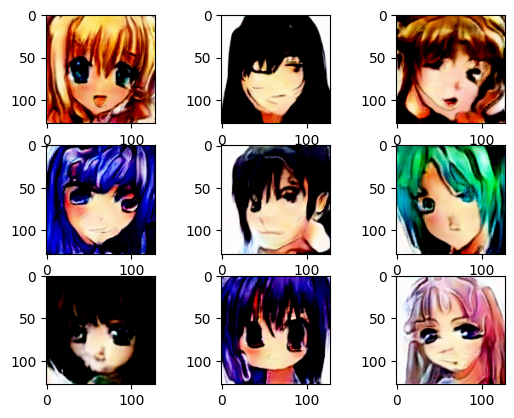

In [64]:
def test_gen(gen):
    r, c = 3, 3
    noise = torch.randn(r*c, config["z_dim"], 1, 1).to(config["device"])

    generated_images = gen(noise, alpha=1, steps=5)
    print(generated_images.shape)

    for i, generated_image in enumerate(generated_images):
        plt.subplot(r, c, i+1)
        #plt.imshow(generated_image.squeeze(0).detach().permute(1, 2, 0).cpu().numpy())
        plt.imshow(generated_image.squeeze(0).detach().permute(1, 2, 0).cpu().numpy())
    plt.show()

gen = Generator(config["z_dim"], config["in_channels"], config["rgb_channels"]).to(config["device"])
gen.load_state_dict(load_model(config)["gen"])
test_gen(gen)

### Conclusion
* The result doesn't really loook that good 
* But I found something interesting while twicking the alpha and steps
* Here's what I saw:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Loading models...
Loaded from ./models/progan2.pt
torch.Size([9, 3, 256, 256])


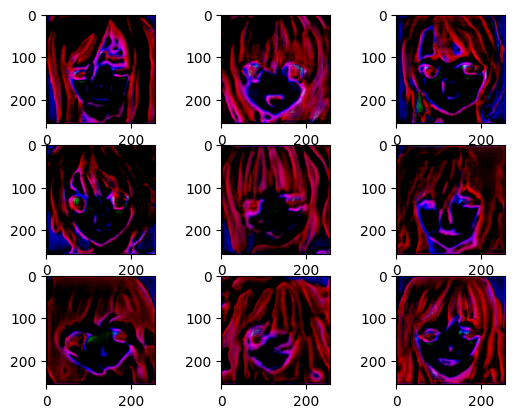

In [56]:
def test_gen(gen):
    r, c = 3, 3
    noise = torch.randn(r*c, config["z_dim"], 1, 1).to(config["device"])

    generated_images = gen(noise, alpha=1, steps=6)
    print(generated_images.shape)

    for i, generated_image in enumerate(generated_images):
        plt.subplot(r, c, i+1)
        #plt.imshow(generated_image.squeeze(0).detach().permute(1, 2, 0).cpu().numpy())
        plt.imshow(generated_image.squeeze(0).detach().permute(1, 2, 0).cpu().numpy())
    plt.show()

gen = Generator(config["z_dim"], config["in_channels"], config["rgb_channels"]).to(config["device"])
gen.load_state_dict(load_model(config)["gen"])
test_gen(gen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Loading models...
Loaded from ./models/progan2.pt
torch.Size([9, 3, 128, 128])


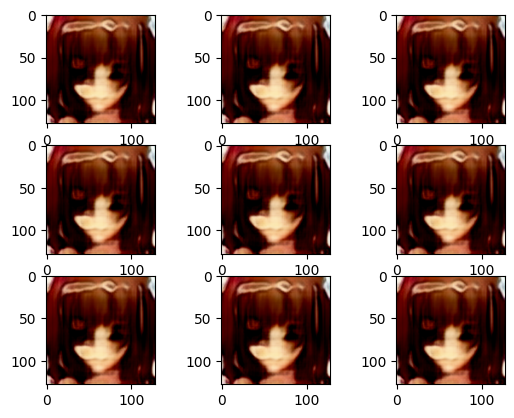

In [62]:
def test_gen(gen):
    r, c = 3, 3
    noise = torch.zeros(r*c, config["z_dim"], 1, 1).to(config["device"])

    generated_images = gen(noise, alpha=1, steps=5)
    print(generated_images.shape)

    for i, generated_image in enumerate(generated_images):
        plt.subplot(r, c, i+1)
        #plt.imshow(generated_image.squeeze(0).detach().permute(1, 2, 0).cpu().numpy())
        plt.imshow(generated_image.squeeze(0).detach().permute(1, 2, 0).cpu().numpy())
    plt.show()

gen = Generator(config["z_dim"], config["in_channels"], config["rgb_channels"]).to(config["device"])
gen.load_state_dict(load_model(config)["gen"])
test_gen(gen)